# Evaluate the impacts of climate change on streamflow

This notebook shows how we can work with climate model data to evaluate the impacts of climate change on hydrology. We will apply a processing chain to the data from the previous example on the Mistassini catchment and we will see how to implement the full 
process in PAVICS-Hydro.

We will first start by setting up the required information to make a GR4JCN model, including calibrated parameters and properties generated in the previous example: 

In [1]:
# Import required packages
import datetime as dt
import json
import warnings

import gcsfs
import intake
import numpy as np
import xarray as xr
import xclim
import xclim.sdba as sdba
from clisops.core import average, subset
from ravenpy.models import GR4JCN

# The platform provides lots of user warnings and information points. We will disable them for now.
warnings.filterwarnings("ignore")

# Load the properties and calibrated parameters from the previous example
all_properties = json.load(open("properties_basin_574_HYSETS.txt"))
parameters = np.loadtxt("optimized_parameters_GR4JCN_basin_574_HYSETS.txt")

# Get the basin contour shapefile, as the previous example
basin_contour = "shapefile_basin_574_HYSETS.zip"

# Setup the GR4JCN HRU that will be used to build the model later, making use of the previously-obtained catchment properties
hru = GR4JCN.LandHRU(
    area=all_properties["area"],
    elevation=all_properties["elevation"],
    latitude=all_properties["latitude"],
    longitude=all_properties["longitude"],
)

## Extract climate model data

PAVICS-Hydro makes use of the PanGEO catalog to obtain CMIP6 project data directly from Google Cloud Services. This makes obtaining data much more efficient. This next section shows how to implement this data extraction for a climate model, but you can access more climate models and datasets by following the tutorial on PAVICS-Hydro.

In [2]:
# Start by setting up the reference and future start and end days. Reference data is used to calibrate the bias-correction algorithms that will be applied to the future data.
reference_start_day = dt.datetime(1980, 1, 1) - dt.timedelta(days=1)
reference_end_day = dt.datetime(1991, 12, 31) + dt.timedelta(
    days=1
)  # Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.
future_start_day = dt.datetime(2080, 1, 1) - dt.timedelta(days=1)
future_end_day = dt.datetime(2091, 12, 31) + dt.timedelta(
    days=1
)  # Notice we are using one day before and one day after the desired period of 2080-01-01 to 2090-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.

# Climate model to use
climate_model = "MIROC6"


# Get the catalog info from the pangeo dataset, which basically is a list of links to the various products.
fsCMIP = gcsfs.GCSFileSystem(token="anon", access="read_only")
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)

# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):
    # Load the files from the PanGEO catalogs, for reference and future variables of temperature and precipitation.
    out = {}
    for exp in ["historical", "ssp585"]:
        if exp == "historical":
            period_start = reference_start_day
            period_end = reference_end_day
        else:
            period_start = future_start_day
            period_end = future_end_day

        out[exp] = {}
        for variable in ["tasmin", "tasmax", "pr"]:
            print(exp, variable)
            query = dict(
                experiment_id=exp,
                table_id="day",
                variable_id=variable,
                member_id="r1i1p1f1",
                source_id=climate_model,
            )
            col_subset = col.search(require_all_on=["source_id"], **query)
            mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])

            # special case for precipitation, which does not have the "height" variable that we need to discard as for tasmax and tasmin.
            if variable == "pr":
                out[exp][variable] = average.average_shape(
                    xr.open_zarr(mapper, consolidated=True).sel(
                        time=slice(period_start, period_end)
                    )[variable],
                    basin_contour,
                ).chunk(-1)
            else:
                out[exp][variable] = average.average_shape(
                    xr.open_zarr(mapper, consolidated=True)
                    .sel(time=slice(period_start, period_end))
                    .reset_coords("height", drop=True)[variable],
                    basin_contour,
                ).chunk(-1)

# We can now extract the variables that we will need later:
historical_tasmax = out["historical"]["tasmax"]
historical_tasmin = out["historical"]["tasmin"]
historical_pr = out["historical"]["pr"]
future_tasmax = out["ssp585"]["tasmax"]
future_tasmin = out["ssp585"]["tasmin"]
future_pr = out["ssp585"]["pr"]

historical tasmin


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


historical tasmax
historical pr
ssp585 tasmin
ssp585 tasmax
ssp585 pr


## Get the historical period data (observations or equivalent)

These data were computed in the previous example, but we will re-extract them to keep the code easier to understand and integrate with other workflows.

In [3]:
# Regenerate the ERA5 data to be sure. In an operational context, you could combine everything onto one notebook and ensure that the
# dates and locations are constant!

# Get the ERA5 data from the Wasabi/Amazon S3 server.
catalog_name = "https://raw.githubusercontent.com/hydrocloudservices/catalogs/main/catalogs/atmosphere.yaml"
cat = intake.open_catalog(catalog_name)
ds = cat.era5_reanalysis_single_levels.to_dask()

"""
Get the ERA5 data. We will rechunk it to a single chunck to make it compatible with other codes on the platform, especially bias-correction.
We are also taking the daily min and max temperatures as well as the daily total precipitation.
"""
# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):
    ERA5_reference = subset.subset_shape(
        ds.sel(time=slice(reference_start_day, reference_end_day)), basin_contour
    ).mean({"latitude", "longitude"})
    ERA5_tmin = ERA5_reference["t2m"].resample(time="1D").min().chunk(-1, -1, -1)
    ERA5_tmax = ERA5_reference["t2m"].resample(time="1D").max().chunk(-1, -1, -1)
    ERA5_pr = ERA5_reference["tp"].resample(time="1D").sum().chunk(-1, -1, -1)

## Change units

Climate models and reanalysis datasets have often differing units to those expected by Raven. Here we update units to make them compatible

In [4]:
# Here we need to make sure that our units are all in the correct format. You can play around with the tools we've seen thus far to explore the units
# and make sure everything is consistent.

# Let's start with precipitation:
ERA5_pr = xclim.core.units.convert_units_to(ERA5_pr, "mm", context="hydro")
# The CMIP data is a rate rather than an absolute value, so let's get the absolute values:
historical_pr = xclim.core.units.rate2amount(historical_pr)
future_pr = xclim.core.units.rate2amount(future_pr)

# Now we can actually convert units in absolute terms.
historical_pr = xclim.core.units.convert_units_to(historical_pr, "mm", context="hydro")
future_pr = xclim.core.units.convert_units_to(future_pr, "mm", context="hydro")

# Now let's do temperature:
ERA5_tmin = xclim.core.units.convert_units_to(ERA5_tmin, "degC")
ERA5_tmax = xclim.core.units.convert_units_to(ERA5_tmax, "degC")
historical_tasmin = xclim.core.units.convert_units_to(historical_tasmin, "degC")
historical_tasmax = xclim.core.units.convert_units_to(historical_tasmax, "degC")
future_tasmin = xclim.core.units.convert_units_to(future_tasmin, "degC")
future_tasmax = xclim.core.units.convert_units_to(future_tasmax, "degC")

## Apply bias-correction to the climate model data

Here is where we perform the bias-correction to the reference and future climate data in order to remove biases as seen between the reference and historical data. The future dataset is then corrected with the same adjustment factors as those in the reference period.

In [5]:
# Use xclim utilities (sbda) to give information on the type of window used for the bias correction.
group_month_window = sdba.utils.Grouper("time.dayofyear", window=15)

# This is an adjusting function. It builds the tool that will perform the corrections.
Adjustment = sdba.DetrendedQuantileMapping.train(
    ref=ERA5_pr, hist=historical_pr, nquantiles=50, kind="+", group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_precip = Adjustment.adjust(historical_pr, interp="linear")

# Apply the correction factors on the future period
corrected_fut_precip = Adjustment.adjust(future_pr, interp="linear")

# Ensure that the precipitation is non-negative, which can happen with some climate models
corrected_ref_precip = corrected_ref_precip.where(corrected_ref_precip > 0, 0)
corrected_fut_precip = corrected_fut_precip.where(corrected_fut_precip > 0, 0)

# Train the model to find the correction factors for the maximum temperature (tasmax) data
Adjustment = sdba.DetrendedQuantileMapping.train(
    ref=ERA5_tmax,
    hist=historical_tasmax,
    nquantiles=50,
    kind="+",
    group=group_month_window,
)

# Apply the correction factors on the reference period
corrected_ref_tasmax = Adjustment.adjust(historical_tasmax, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmax = Adjustment.adjust(future_tasmax, interp="linear")

# Train the model to find the correction factors for the minimum temperature (tasmin) data
Adjustment = sdba.DetrendedQuantileMapping.train(
    ref=ERA5_tmin,
    hist=historical_tasmin,
    nquantiles=50,
    kind="+",
    group=group_month_window,
)

# Apply the correction factors on the reference period
corrected_ref_tasmin = Adjustment.adjust(historical_tasmin, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmin = Adjustment.adjust(future_tasmin, interp="linear")

## Generate the NetCDF files

Now that the datasets are created, we can generate files so that Raven can access them. This might take a bit of time since everything up until now has been done in a "lazy" framework by Python. Data processing is actually just now really starting.

In [6]:
# Convert the reference corrected data into netCDF file. We will then apply a special code to remove a dimension in the dataset to make it applicable to the RAVEN models.
ref_dataset = xr.merge(
    [
        corrected_ref_precip.to_dataset(name="pr"),
        corrected_ref_tasmax.to_dataset(name="tasmax"),
        corrected_ref_tasmin.to_dataset(name="tasmin"),
    ]
)
ref_dataset.to_netcdf("reference_dataset_tmp.nc")

# Convert the future corrected data into netCDF file
fut_dataset = xr.merge(
    [
        corrected_fut_precip.to_dataset(name="pr"),
        corrected_fut_tasmax.to_dataset(name="tasmax"),
        corrected_fut_tasmin.to_dataset(name="tasmin"),
    ]
)
fut_dataset.to_netcdf("future_dataset_tmp.nc")

ref_dataset = xr.open_dataset("reference_dataset_tmp.nc")
ref_dataset.isel(geom=0).squeeze().to_netcdf("reference_dataset.nc")

fut_dataset = xr.open_dataset("future_dataset_tmp.nc")
fut_dataset.isel(geom=0).squeeze().to_netcdf("future_dataset.nc")

## Run the hydrological model with reference and future data

Now that we have all the data we need for the reference and future periods, we can now run GR4JCN to obtain streamflow representative of each period.

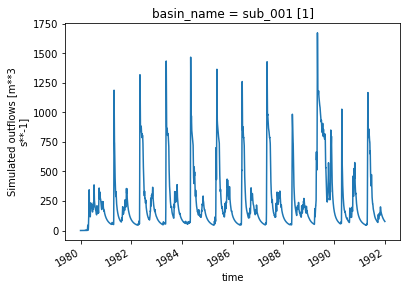

In [7]:
# Start a model instance, in this case a GR4JCN model emulator.
model = GR4JCN()

# Model configuration parameters that will be used for the simulation for both the reference and future periods.
common_run_parameters = dict(
    area=all_properties["area"],
    elevation=all_properties["elevation"],
    latitude=all_properties["latitude"],
    longitude=all_properties["longitude"],
    params=parameters,
    rain_snow_fraction="RAINSNOW_DINGMAN",
)

forcing = "reference_dataset.nc"

# Run the hydrological model using our forcing data from the reference period, and with the common parameters that will also be used for the future period simulation.
model(
    forcing,
    start_date=reference_start_day + dt.timedelta(days=1),
    end_date=reference_end_day - dt.timedelta(days=1),
    **common_run_parameters,
)

# Now plot the results
model.hydrograph.q_sim.plot()

### Now redo the same thing but for the future period.

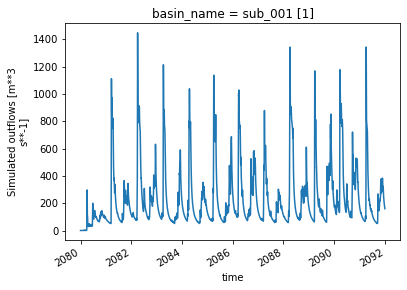

In [8]:
# Start a new model instance
model = GR4JCN()

# Accessing the future data we just created -- notice it is now the "future_dataset.nc" instead of the "reference_dataset.nc"
# Model configuration parameters
model(
    ts="future_dataset.nc",
    start_date=future_start_day
    + dt.timedelta(days=1),  # Now running the future period!
    end_date=future_end_day - dt.timedelta(days=1),
    **common_run_parameters,
)

# And plot the results! We can compare both figures and see the changes between both.
model.hydrograph.q_sim.plot()

## End

We could now download the data to a netcdf file or other medium, and we could analyze the data either locally or on PAVICS-Hydro by appending other blocks of code below where the analysis is performed. 